In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder



# Import Data

In [2]:
Data=pd.read_csv('Data.csv')
Data.drop(['ID','Unnamed: 0'],axis='columns', inplace=True )

In [3]:
###let's check the missing values
Data.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

In [4]:
Data.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1'],
      dtype='object')

### conclusion:  5 variables has missing values: Ever_Married, Graduated, Profession, Work_Experience, Family_Size, Var_1

In [5]:
### let's look at the distribution of numerical values
Data.describe()


,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


### we can see that numerical values are normally distributed and have missing values. 

In [6]:
#let's check if there is any abnormal values in  the categorical variables:
df_cat=Data[['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1']]

for i in df_cat.columns:
    print(df_cat[i].unique())

['Male' 'Female']
['No' 'Yes' nan]
['No' 'Yes' nan]
['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]
['Low' 'Average' 'High']
['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']


### all values are normal,there is no outliers in the data

# Handling Missing Values using Knn

### 1-categorical Missing Values

In [ ]:
df_cat=Data[['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1']]
encoders={}
for col_name in df_cat.columns:
    series = df_cat[col_name]
    label_encoder = LabelEncoder()
    df_cat[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
    )
    encoders[col_name] = label_encoder

### 2-numerical Missing Values:

In [8]:
# for i in ['Age','Work_Experience','Family_Size']:
#      Data[i]=Data[i].astype(float)

In [9]:
df_num=Data[['Age','Work_Experience','Family_Size']]

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df_num.loc[:]=imputer.fit_transform(df_num)

In [ ]:
#Data = Data.replace({'nan': np.nan})
imputer = KNNImputer(n_neighbors=1)

df_cat.loc[:]=imputer.fit_transform(df_cat)

In [12]:
df=pd.concat([df_cat,df_num], axis=1)

# clustering 

In [13]:
#standardization of data to apply KNN
scaler=StandardScaler()
segmentation_std=scaler.fit_transform(df)

In [14]:
def make_list_of_K(K, dataframe):
    
    cluster_values = list(range(2, K+1))
    inertia_values=[]
    
    for c in cluster_values:
        model = KMeans(
            n_clusters = c, 
            init='k-means++', 
            max_iter=500, 
            random_state=42)
        model.fit(dataframe)
        inertia_values.append(model.inertia_)
    
    return inertia_values

In [15]:
clusters = list(range(2, 15+1))
results = make_list_of_K(15,segmentation_std)
k_values_distances = pd.DataFrame({"clusters": clusters,
                                   "within cluster sum of squared distances": results},index=None)
k_values_distances=k_values_distances.set_index('clusters')

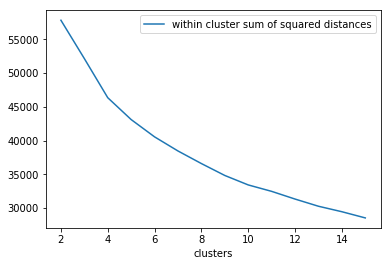

In [16]:
k_values_distances.plot()

### selecting the number of k is not clear, let's use hierarchical clustering!

In [17]:
#hierarchical clustering
hier_clust=linkage(segmentation_std,method='ward')

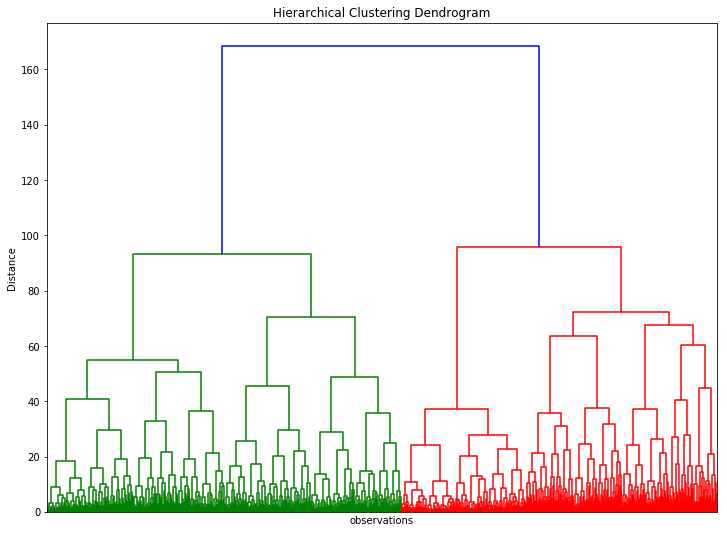

In [18]:
plt.figure(figsize=(12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("observations")
plt.ylabel('Distance')
dendrogram(hier_clust,show_leaf_counts=False,
           truncate_mode='level',
           p=10,
          no_labels=True,
           #color_threshold=0
          )
plt.show()

### there is 2 clusters in the data

In [19]:
#let's build the knn model with 2 clusters:
kmeans = KMeans(
            n_clusters = 2, 
            init='k-means++', 
            max_iter=500, 
            random_state=42)
df['clusters']=kmeans.fit_predict(segmentation_std)

### let's visualize our clusters

In [20]:
#Load Data
pca = PCA(2)
#Transform the data
d_f= pca.fit_transform(segmentation_std)
 
d_f.shape

(8068, 2)

In [21]:
#predict the labels of clusters.
label = kmeans.fit_predict(d_f)
 
print(label)

[1 0 0 ... 1 1 0]


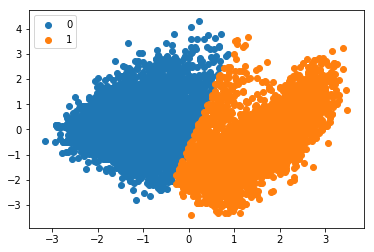

In [22]:
#Getting unique labels
u_labels = np.unique(label)
#plotting the results:
 
for i in u_labels:
    plt.scatter(d_f[label == i , 0] , d_f[label == i , 1] , label = i)
plt.legend()
plt.show()

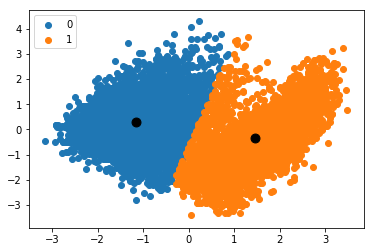

In [23]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(d_f[label == i , 0] , d_f[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

# analysis

In [24]:
#decode categorical data
for i in df_cat.columns:
     df[i]=df[i].astype(int)
for col_name in df_cat.columns:
    df[col_name] = encoders[col_name].inverse_transform(df[col_name])
    


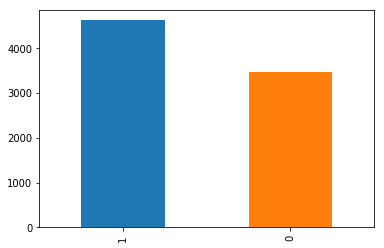

In [25]:
df['clusters'].value_counts().plot(kind='bar')


In [26]:
df.groupby(['clusters']).mean()

,Age,Work_Experience,Family_Size
clusters,,,
0,31.876411,3.096440,3.027207
1,52.147843,2.294039,2.725688


In [27]:
df.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1']]


,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
clusters,,,,,,
0,Female,No,No,Healthcare,Low,Cat_6
1,Male,Yes,Yes,Artist,Average,Cat_6


### we can notice from the clusters informations that cluster 0 has younger clients more of them female and not married    and cluster 1 has more aged clients that are garduated and married . 